In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import joblib
import tabulate as tb
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import Huber
from tensorflow.keras import Sequential, layers, optimizers, losses



In [146]:
CSV_PATH = './../data/GOOGL.csv'
DATE_COL = 'Date'

SEQ_LENGTH = 90
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 30

# FEATURES = [
#     'Open', 'High', 'Low', 'Close', 'Volume',
#     'rsi', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
#     'BBL_20_2.0_2.0','BBM_20_2.0_2.0','BBU_20_2.0_2.0','BBB_20_2.0_2.0','BBP_20_2.0_2.0',
#     'ema_10','ema_20','ema_50','atr','stoch_k','stoch_d'
# ]

FEATURES = [
    'rsi', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
    'BBL_20_2.0_2.0','BBM_20_2.0_2.0','BBU_20_2.0_2.0','BBB_20_2.0_2.0','BBP_20_2.0_2.0',
    'ema_10','ema_20','ema_50','atr','stoch_k','stoch_d'
]

TARGET = 'Close'

TRAINING_RANGE = ('2022-01-01', '2025-09-30')
TESTING_RANGE = ('2025-10-01', '2025-10-20')

In [147]:
df = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)
# df[f"next_{TARGET}"] = df[TARGET].shift(1)
# df = df[[DATE_COL] + FEATURES + [f"next_{TARGET}"]]
df = df[[DATE_COL] + FEATURES + [TARGET]]
df.dropna(inplace=True)
# print(tb.tabulate(df.head(), headers='keys', tablefmt='psql'))

feature_scaler = MinMaxScaler()#MinMaxScaler()
target_scaler = MinMaxScaler()

feature_data = feature_scaler.fit_transform(df[FEATURES])
target_data = target_scaler.fit_transform(df[[TARGET]].values.reshape(-1, 1))

print(tb.tabulate(feature_data[:5], headers=FEATURES, tablefmt='psql'))
print(tb.tabulate(target_data[:5], headers=[TARGET], tablefmt='psql'))

+----------+----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+-------------+-------------+-------------+-----------+-----------+-----------+
|      rsi |   MACD_12_26_9 |   MACDh_12_26_9 |   MACDs_12_26_9 |   BBL_20_2.0_2.0 |   BBM_20_2.0_2.0 |   BBU_20_2.0_2.0 |   BBB_20_2.0_2.0 |   BBP_20_2.0_2.0 |      ema_10 |      ema_20 |      ema_50 |       atr |   stoch_k |   stoch_d |
|----------+----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+-------------+-------------+-------------+-----------+-----------+-----------|
| 0.879182 |       0.359553 |        0.507202 |        0.33678  |      0           |      0           |      0.000696864 |         0.890176 |         0.752319 | 0           | 0           | 0           | 0.0160677 |  0.884602 |  0.865236 |
| 0.837271 |       0.360364 |        0.50580

In [148]:
X, y = [], []
dates = []
for i in range(SEQ_LENGTH, len(feature_data)):
    tmp = feature_data[i - SEQ_LENGTH:i]
    X.append(tmp)
    dates.append(df[DATE_COL].values[i])
    y.append(target_data[i])

X, y = np.array(X), np.array(y)

print(f"Feature data shape: {X.shape}")
print(f"Target data shape: {y.shape}")

Feature data shape: (5187, 90, 15)
Target data shape: (5187, 1)


In [149]:
def find_closest_date_index(dates_array, target_date):
    target_date = np.datetime64(target_date)
    index = np.argmin(np.abs(dates_array - target_date))
    return index

train_beg, train_end = find_closest_date_index(dates, TRAINING_RANGE[0]), find_closest_date_index(dates, TRAINING_RANGE[1])
test_beg, test_end = find_closest_date_index(dates, TESTING_RANGE[0]), find_closest_date_index(dates, TESTING_RANGE[1])

print(f"Training: beg_idx={train_beg} -> beg={dates[train_beg]} || end_idx={train_end} -> end={dates[train_end]}")
print(f"Testing:  beg_idx={test_beg} -> beg={dates[test_beg]} || end_idx={test_end} -> end={dates[test_end]}")

X_train, y_train = X[train_beg:train_end+1], y[train_beg:train_end+1]
X_test, y_test = X[test_beg:test_end+1], y[test_beg:test_end+1]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Training: beg_idx=4234 -> beg=2021-12-31T00:00:00.000000000 || end_idx=5173 -> end=2025-09-30T00:00:00.000000000
Testing:  beg_idx=5174 -> beg=2025-10-01T00:00:00.000000000 || end_idx=5186 -> end=2025-10-17T00:00:00.000000000
X_train shape: (940, 90, 15), y_train shape: (940, 1)
X_test shape: (13, 90, 15), y_test shape: (13, 1)


In [150]:
def create_financial_model(seq_length, feature_count, learning_rate):
    model = Sequential([
        layers.Input(shape=(seq_length, feature_count)),
        
        # --- Block 1 ---
        layers.LSTM(96, return_sequences=True),
        layers.LayerNormalization(),
        layers.Dropout(0.1),
        
        # --- Block 2 ---
        layers.LSTM(96, return_sequences=True),
        layers.LayerNormalization(),
        layers.Dropout(0.05),
        
        # --- Block 3 ---
        layers.LSTM(64, return_sequences=False),
        layers.LayerNormalization(),
        layers.Dropout(0.05),
        
        # --- Residual dense block ---
        layers.Dense(64, activation='relu'),
        layers.LayerNormalization(),
        layers.Dense(32, activation='relu'),
        
        # --- Output ---
        layers.Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss=losses.Huber(delta=1.0),
        metrics=["mae"]
    )
    
    model.summary()
    return model
model = create_financial_model(SEQ_LENGTH, len(FEATURES), LEARNING_RATE)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_51 (LSTM)                  │ (None, 90, 96)         │        43,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_20          │ (None, 90, 96)         │           192 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 90, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 90, 96)         │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_21          │ (None, 90, 96)         │           192 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 90, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_22          │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_23          │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,249 (645.50 KB)

 Trainable params: 165,249 (645.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step
+-----+---------------------+----------+-------------+
|     | Date                |   Actual |   Predicted |
|-----+---------------------+----------+-------------|
|   0 | 2024-12-31 00:00:00 |  188.685 |     177.196 |
|   1 | 2025-01-02 00:00:00 |  188.814 |     177.156 |
|   2 | 2025-01-03 00:00:00 |  191.167 |     176.98  |
|   3 | 2025-01-06 00:00:00 |  196.23  |     176.751 |
|   4 | 2025-01-07 00:00:00 |  194.855 |     176.741 |
|   5 | 2025-01-08 00:00:00 |  193.32  |     176.926 |
|   6 | 2025-01-10 00:00:00 |  191.416 |     177.339 |
|   7 | 2025-01-13 00:00:00 |  190.389 |     177.783 |
|   8 | 2025-01-14 00:00:00 |  189.044 |     178.198 |
|   9 | 2025-01-15 00:00:00 |  194.915 |     178.452 |
|  10 | 2025-01-16 00:00:00 |  192.283 |     178.822 |
|  11 | 2025-01-17 00:00:00 |  195.363 |     179.054 |
|  12 | 2025-01-21 00:00:00 |  197.406 |     179.512 |
|  13 | 2025-01-22 00:00:00 |  197.725 |     180.034 |
|  14 | 2025-01-23 00:00:0

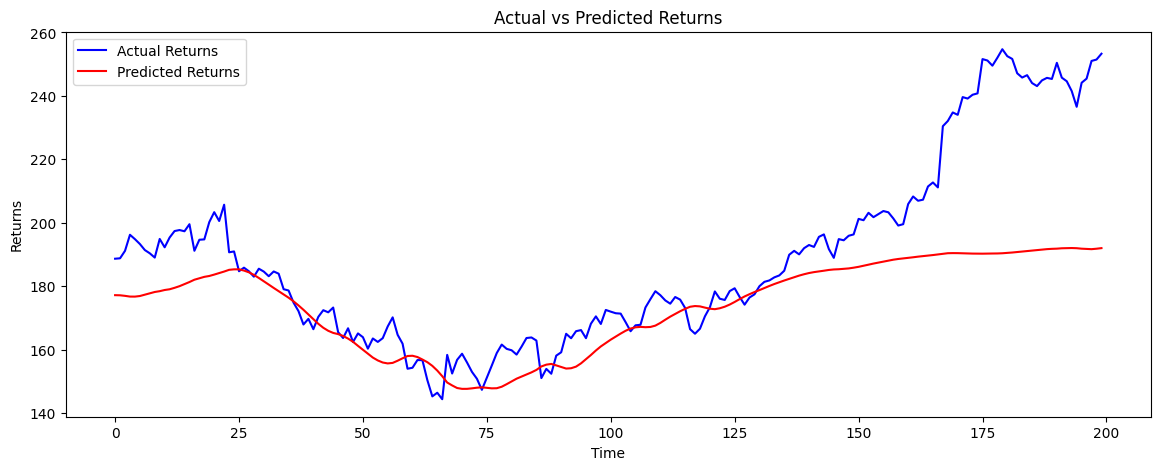

In [ ]:
predictions_scaled = model.predict(X_test)
predictions = target_scaler.inverse_transform(predictions_scaled).flatten()
y_test_unscaled = target_scaler.inverse_transform(y_test).flatten()

comp_df = pd.DataFrame({
    'Date': df[DATE_COL].values[test_beg + SEQ_LENGTH:test_end + SEQ_LENGTH + 1],
    'Actual': y_test_unscaled,
    'Predicted': predictions
})
print(tb.tabulate(comp_df, headers='keys', tablefmt='psql'))

mse = mean_squared_error(y_test_unscaled, predictions)
mae = mean_absolute_error(y_test_unscaled, predictions)
r2 = r2_score(y_test_unscaled, predictions)
print(f"Test MSE: {mse:.3f}")
print(f"Test MAE: {mae:.3f}")
print(f"Test R2: {r2:.3f}")


plt.figure(figsize=(14, 5))
plt.plot(y_test_unscaled, color='blue', label='Actual Returns')
plt.plot(predictions, color='red', label='Predicted Returns')
plt.title('Actual vs Predicted Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()